In [1]:
import pandas as pd
import pickle
import sys
import matplotlib.pyplot as plt
sys.path.append("../code/")
out_overall = pickle.load(open('../data/input/all_regions.pkl', 'r'))
from common_functions import tableau20blind, format_axes, latexify
from regional_average_contribution import contribution

In [2]:
%matplotlib inline

In [3]:
def get_fhmm(appliance, test_region='SanDiego'):
    count = 0
    
    test_df = out_overall[test_region]
    #test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]

    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    out[appliance] = {}
    test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
    for test_home in test_df_appliance.index:
        try:
            pred_df = pd.read_csv("/Users/nipunbatra/wiki-15min-fhmm-out/%s_%d.csv" %(test_region, test_home),index_col=0)
            pred_df_appliance = pred_df[appliance].ix[start:stop-1]
            gt_df_appliance = test_df.ix[test_home][['%s_%d' %(appliance, month) for month in range(start, stop)]]
            gt_df_appliance.index = pred_df_appliance.index
            error = ((pred_df_appliance-gt_df_appliance).abs()*100/gt_df_appliance)
            #error[error>100]=100
            #acc = 100-error
            out[appliance][test_home]=error
        except:
            pass
    return pd.DataFrame(out[appliance]).T.median().mean(), pd.DataFrame(out[appliance]).T.median()

In [4]:
def get_regional_average(appliance, test_region='Austin'):
    contri_austin_appliance = contribution[test_region]['Cooling'][appliance]
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    test_df = out_overall[test_region]
    #test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
        
    test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
    pred_df = test_df_appliance[['aggregate_%d' %month for month in range(start, stop)]]*contri_austin_appliance
    gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
    gt_df.columns = pred_df.columns
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    return error.median().mean(), error.median()

In [5]:
def get_lbm(appliance, region):
    if region=="Austin":
        lbm_pred_df = pickle.load(open('../data/output/lbm_15_Austin.pkl'))
    else:
        lbm_pred_df = pickle.load(open('../data/output/lbm_15_SD.pkl'))
    if appliance=="hvac":
        start, stop=5, 11
    else:
        start, stop=1, 13
    test_df = out_overall[region]
    #test_df=test_df[(test_df.full_agg_available==1)&(test_df.md_available==1)]
    pred_df = lbm_pred_df[['%s_%d' %(appliance,month) for month in range(start,stop)]]

    test_df_appliance=test_df.ix[test_df[['%s_%d' %(appliance,month) for month in range(start,stop)]].dropna().index]
    gt_df = test_df_appliance[['%s_%d' %(appliance, month) for month in range(start, stop)]]
    gt_df.columns = pred_df.columns
    error = (gt_df-pred_df).abs().div(gt_df).mul(100)
    return error.median().mean(), error.median()

In [6]:
train_region = "Austin"
test_region = "SanDiego"
#test_region = "Austin"
#train_region = "Boulder"
out_overall = pickle.load(open('../data/input/all_regions.pkl','r'))

train_df = out_overall[train_region]
test_df = out_overall[test_region]
#transform = "DD"
k=3
transformations = ["None","DD","DD-percentage",'median-aggregate',"median-aggregate-percentage",'regional','regional-percentage']
#transformations = ['DD','None',"DD-fridge"]

In [7]:
import os
import numpy as np

In [8]:
out = {}
for transform in transformations[:]:
    out[transform] = {}
    #for appliance in ["hvac","fridge","dr","wm"]:
    for appliance in ['fridge','wm','oven','mw','dw','hvac']:
        if appliance=="hvac":
            start, stop=5, 11
        else:
            start, stop=1, 13
        out[transform][appliance] = {}
        for month in range(start,stop):
            out[transform][appliance][month] = {}
            for test_home in test_df.index:
                try:
                    pred =  pickle.load(open(os.path.expanduser('~/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                                               test_region,
                                                                                               transform,
                                                                                               appliance,
                                                                                               month,
                                                                                               test_home,
                                                                                               k)),'r'))
                    gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                    error = np.abs(gt-pred)
                    percentage_error = error*100/gt
                   
                    out[transform][appliance][month][test_home] = percentage_error
                except Exception, e:
                    pass

In [9]:
o = {}
for appliance in ['fridge','hvac','dw','wm','mw','oven']:
    o[appliance]={}
    for transformation in transformations:
        o[appliance][transformation] = pd.DataFrame(out[transformation][appliance]).median().mean()
    

In [10]:
sd_austin_sensitivity_df = pd.DataFrame(o).T

In [11]:
sd_austin_sensitivity_df

,DD,DD-percentage,None,median-aggregate,median-aggregate-percentage,regional,regional-percentage
dw,97.464846,85.725734,98.039990,83.253913,81.170578,94.277738,91.360469
fridge,22.911839,24.681317,25.311113,49.203124,47.408082,25.069897,29.359869
hvac,161.748253,174.194380,389.597911,237.941811,234.615654,169.147599,151.618649
mw,40.405165,44.258548,50.265087,63.245271,58.312454,40.256870,44.181603
oven,153.125293,106.784550,154.686657,62.937021,59.892263,142.254365,96.181486
wm,58.112078,67.448037,50.391513,53.993319,48.856423,54.101156,47.912962


In [12]:
pd.DataFrame(out['DD']['hvac']).median()

5     667.184530
6     176.142114
7      27.854608
8      19.965708
9      47.170816
10     32.171744
dtype: float64

In [13]:
pd.DataFrame(out['DD-percentage']['hvac']).median()

5     768.429994
6     190.817842
7      20.963491
8      10.445682
9      18.445947
10     36.063325
dtype: float64

In [14]:
pd.DataFrame(out['regional-percentage']['hvac']).median()

5     582.711008
6     129.062278
7      34.454765
8      36.573838
9      59.476337
10     67.433668
dtype: float64

In [15]:
best_transform_sd_austin = {'fridge':'DD',
                           'hvac':'DD-percentage',
                           'wm':'median-aggregate-percentage',
                           'mw':'regional',
                           'dw':'median-aggregate-percentage',
                           'oven':'median-aggregate-percentage'}

In [16]:
vistrit = pd.Series({appliance:sd_austin_sensitivity_df.loc[appliance, best_transform_sd_austin[appliance]] for appliance in ['fridge','hvac','dw','wm','mw','oven']})

In [17]:
vistrit

dw         81.170578
fridge     22.911839
hvac      174.194380
mw         40.256870
oven       59.892263
wm         48.856423
dtype: float64

In [18]:
regional_average_results={}
for appliance in ['fridge','hvac','dw','wm','mw','oven']:
    try:
        regional_average_results[appliance] = get_regional_average(appliance,'SanDiego')[0]
    except:
        pass
regional_average_results = pd.Series(regional_average_results)

In [19]:
regional_average_results

dw         78.839639
fridge     31.610986
hvac      186.109032
wm         25.357839
dtype: float64

In [20]:
lbm_results={}
for appliance in ['fridge','hvac','dw','wm','mw','oven']:
    try:
        lbm_results[appliance] = get_lbm(appliance,'SanDiego')[0]
    except:
        pass
lbm_results = pd.Series(lbm_results)

In [21]:
lbm_results

dw        119.119638
fridge     24.963334
hvac      801.565733
mw         84.575592
oven      298.296037
wm         68.713143
dtype: float64

In [22]:
fhmm_results={}
for appliance in ['fridge','hvac','dw','wm','mw','oven']:
    try:
        fhmm_results[appliance] = get_fhmm(appliance,'SanDiego')[0]
    except:
        pass
fhmm_results = pd.Series(fhmm_results)

In [23]:
fhmm_results

dw        1149.002583
fridge      44.812767
hvac       348.831626
mw         665.923213
oven      1079.187722
wm         764.493403
dtype: float64

In [24]:
austin_sd_results = pd.DataFrame({"FHMM":fhmm_results,"Regional average":regional_average_results,
                                 "LBM":lbm_results,'Vistrit':vistrit})

In [25]:
austin_sd_results = austin_sd_results.ix[['fridge','hvac','wm','mw','dw','oven']]

In [26]:
austin_sd_results.index = ['Fridge','HVAC','Washing\nmachine','Micro-\nwave','Dish\nwasher','Oven']

In [27]:
latexify(columns=1)

/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
/Users/nipunbatra/anaconda/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: text.fontsize is deprecated and replaced with font.size; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


/Users/nipunbatra/anaconda/lib/python2.7/site-packages/pandas/tools/plotting.py:929: UserWarning: 'colors' is being deprecated. Please use 'color'instead of 'colors'
  warnings.warn(("'colors' is being deprecated. Please use 'color'"


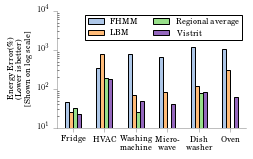

In [28]:
colors = [tableau20blind[x] for x in [1,3,5, 8]]
austin_sd_results.plot(kind="bar", logy=True, rot=0, colors=colors).legend(ncol=2)
format_axes(plt.gca())
plt.ylabel("Energy Error(\%)\n(Lower is better)\n[Shown on log scale]")
plt.savefig('../results/austin_sd.pdf',bbox_inches="tight")

In [30]:
hvac_vistrit = pd.DataFrame(out['DD-percentage']['hvac']).median()

In [31]:
hvac_lbm = get_lbm("hvac",'SanDiego')[1]
hvac_lbm.index = hvac_vistrit.index
hvac_lbm

5     3823.433244
6      684.493837
7      110.765458
8       52.806074
9       28.268701
10     109.627086
dtype: float64

In [32]:
hvac_fhmm = get_fhmm("hvac",'SanDiego')[1]
hvac_fhmm.index = hvac_vistrit.index
hvac_fhmm

5     1893.887897
6      111.280708
7       16.562889
8       25.061188
9       32.438532
10      13.758540
dtype: float64

In [33]:
hvac_ra = get_regional_average("hvac",'SanDiego')[1]
hvac_ra.index = hvac_vistrit.index
hvac_ra

5     760.973139
6      71.025877
7      70.543116
8      75.268387
9      77.074877
10     61.768798
dtype: float64

In [34]:
hvac_sensitivity = pd.DataFrame({"FHMM":hvac_fhmm,"LBM":hvac_lbm,"Regional average":hvac_ra,"Vistrit":hvac_vistrit})

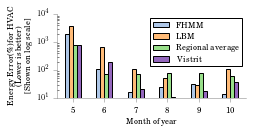

In [38]:
latexify(columns=1, fig_height=1.5)
hvac_sensitivity.plot(kind="bar", logy=True,rot=0, colors=colors)
plt.xlabel("Month of year")
format_axes(plt.gca())
plt.ylabel("Energy Error(\%) for HVAC\n(Lower is better)\n[Shown on log scale]")
plt.savefig('../results/austin_sd_hvac.pdf',bbox_inches="tight")

In [33]:
def prepare_sensitivity_df(df):
    df = df[['None','DD',
     'DD-percentage',
     'median-aggregate',
     'median-aggregate-percentage',
     'regional',
     'regional-percentage']]
    df.columns = [('None','Energy'),('Degree days','Energy'),('Degree days','Proportion'),
              ('Median aggregate','Energy'),('Median aggregate','Proportion'),
             ('Regional average','Energy'),('Regional average','Proportion')]
    df = df.ix[['fridge','hvac','wm','mw','dw','oven']]
    df.index = ['Fridge','HVAC','Washing\nmachine','Micro-\wave','Dish\nwasher','Oven']
    return df


In [34]:
sd_austin_sensitivity_df = prepare_sensitivity_df(sd_austin_sensitivity_df)

In [36]:
sd_austin_sensitivity_df

,"(None, Energy)","(Degree days, Energy)","(Degree days, Proportion)","(Median aggregate, Energy)","(Median aggregate, Proportion)","(Regional average, Energy)","(Regional average, Proportion)"
Fridge,24.128198,23.342505,50.743108,114.031521,115.146362,23.569190,50.400313
HVAC,59.409228,44.067202,26.634442,45.789630,44.567010,57.618993,42.504396
Washing\nmachine,49.915222,49.881359,156.769185,150.403044,175.704316,49.847082,132.384986
Micro-\wave,100.679071,74.783124,67.988560,226.434338,177.786037,156.445856,156.875642
Dish\nwasher,63.309244,63.846612,96.856467,87.461178,86.588917,66.420398,89.754732
Oven,51.619391,49.990886,133.579291,86.376343,136.489064,70.621527,65.341836


In [35]:
pickle.dump(sd_austin_sensitivity_df, open('../data/output/sd_austin_sensitivity_transform.pkl','w'))

In [8]:
pd.DataFrame(out['DD-percentage']['fridge']).median().mean()

50.743107772985155

In [15]:
o = {}
for transformation in transformations:
    o[transformation] = pd.DataFrame(out[transformation]['oven']).median().mean()
    

In [16]:
pd.Series(o)

DD                              49.990886
DD-percentage                  133.579291
None                            51.619391
median-aggregate                86.376343
median-aggregate-percentage    136.489064
regional                        70.621527
regional-percentage             65.341836
dtype: float64

In [38]:
sd_austin_sensitivity_df

,"(None, Energy)","(Degree days, Energy)","(Degree days, Proportion)","(Median aggregate, Energy)","(Median aggregate, Proportion)","(Regional average, Energy)","(Regional average, Proportion)"
Fridge,24.128198,23.342505,50.743108,114.031521,115.146362,23.569190,50.400313
HVAC,59.409228,44.067202,26.634442,45.789630,44.567010,57.618993,42.504396
Washing\nmachine,49.915222,49.881359,156.769185,150.403044,175.704316,49.847082,132.384986
Micro-\wave,100.679071,74.783124,67.988560,226.434338,177.786037,156.445856,156.875642
Dish\nwasher,63.309244,63.846612,96.856467,87.461178,86.588917,66.420398,89.754732
Oven,51.619391,49.990886,133.579291,86.376343,136.489064,70.621527,65.341836
